### setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
import re
import string

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import swifter
from tqdm import tqdm
tqdm.pandas()

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('omw-1.4')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('averaged_perceptron_tagger_eng')

In [5]:
path_to_folder = "C:/Users/phku0/Quant_Project"

### 1. clean text

In [3]:
df = pd.read_parquet(path_to_folder+"/data_raw/glassd_review_internal_data_2024-03-19.parquet")

In [4]:
print(df.shape)
df.head()

(4337584, 7)


,reviewId,summary,pros,cons,advice,other_data,updateDateTime
0,49,A great internship experience.,All people are helpful. We create products tha...,"No, I don\'t really think there\'s any downside.",This is a great company. I just hope everybody...,"{""isLegal"": true, ""employer"": {""__ref"": ""Emplo...",2023-08-28 01:54:58
1,59,Microsoft - when it stopped treating all of it...,Lots of smart folks doing a wide variety of th...,Unless you are a Partner the company treats yo...,Excellence in people management can\'t come fr...,"{""isLegal"": true, ""employer"": {""__ref"": ""Emplo...",2023-08-28 01:54:58
2,77,"Good company to work for, but keep in mind tha...",The culture of the company is one of the best ...,Apple is a very exclusive company to work for ...,Recognize when an employee might feel like the...,"{""isLegal"": true, ""employer"": {""__ref"": ""Emplo...",2023-08-28 01:54:58
3,81,Apple is unlike any other retail organization.,Apple is very serious about promoting from wit...,"In the end it is still retail. So, there are ...",Keep up the good work.,"{""isLegal"": true, ""employer"": {""__ref"": ""Emplo...",2023-08-28 01:54:58
4,83,An inside bite into Apple,Apple is a great place to be updated with the ...,As employees we are constantly expected to add...,Sometimes I feel like our company is too forwa...,"{""isLegal"": true, ""employer"": {""__ref"": ""Emplo...",2023-08-28 01:54:58


In [5]:
# drop advice column (58% missing)
df.drop(['updateDateTime', 'other_data', 'advice'], axis=1, inplace=True)

df = df.dropna(subset=['summary'])
df = df.fillna('')

# Initialization
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True) # suitable for informal text
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)

# Precompile the regular expressions
newline_re = re.compile(r'\r?\n+')
quote_re = re.compile(r"’")
dots_re = re.compile(r'\.{2,}')
backslash_re = re.compile(r'\\')
whitespace_re = re.compile(r'\s+')

# Map POS tag for lemmatization
def get_POS(word):
  tag = pos_tag([word])[0][1][0].lower()
  tag_dict = {'j': wordnet.ADJ, 'n': wordnet.NOUN, 'v': wordnet.VERB, 'r': wordnet.ADV}
  return tag_dict.get(tag, wordnet.NOUN)

def cleanText(text):
  text = newline_re.sub('. ', text) # same as text = re.sub(r'\r?\n+', '. ', text) etc
  text = quote_re.sub("'", text)
  text = dots_re.sub('.', text)
  text = backslash_re.sub('', text)
  text = whitespace_re.sub(' ', text)
  text = text.strip().lower()
  return text

def tokenize(text):
  tokens = tokenizer.tokenize(text)
  tokens = [word for word in tokens if word not in stop_words and word not in punctuation_set and len(word) > 1]
  tokens = [lemmatizer.lemmatize(word, get_POS(word)) for word in tokens]
  return tuple(tokens)

df[['summary', 'pros', 'cons']] = df[['summary', 'pros', 'cons']].swifter.applymap(cleanText)

Pandas Apply:   0%|          | 0/12961872 [00:00<?, ?it/s]

In [6]:
df.head()

,reviewId,summary,pros,cons
0,49,a great internship experience.,all people are helpful. we create products tha...,"no, i don't really think there's any downside."
1,59,microsoft - when it stopped treating all of it...,lots of smart folks doing a wide variety of th...,unless you are a partner the company treats yo...
2,77,"good company to work for, but keep in mind tha...",the culture of the company is one of the best ...,apple is a very exclusive company to work for ...
3,81,apple is unlike any other retail organization.,apple is very serious about promoting from wit...,"in the end it is still retail. so, there are o..."
4,83,an inside bite into apple,apple is a great place to be updated with the ...,as employees we are constantly expected to add...


In [7]:
df.to_parquet(path_to_folder+'/data_NLP_checkpoints/1.cleaned_text.parquet')

### 2. tokenize & lemmatize

In [8]:
df = pd.read_parquet(path_to_folder+"/data_NLP_checkpoints/1.cleaned_text.parquet")

In [ ]:
def tokenize(text):
  tokens = tokenizer.tokenize(text)
  tokens = [word for word in tokens if word not in stop_words and word not in punctuation_set and len(word) > 1]
  tokens = [lemmatizer.lemmatize(word, get_POS(word)) for word in tokens]
  return tuple(tokens)

df[['summary_token', 'pros_token', 'cons_token']] = df[['summary', 'pros', 'cons']].swifter.applymap(tokenize)

In [9]:
df.head()

,reviewId,summary,pros,cons,summary_token,pros_token,cons_token
0,49,a great internship experience.,all people are helpful. we create products tha...,"no, i don't really think there's any downside.","(great, internship, experience)","(people, helpful, create, product, impact, wor...","(really, think, there's, downside)"
1,59,microsoft - when it stopped treating all of it...,lots of smart folks doing a wide variety of th...,unless you are a partner the company treats yo...,"(microsoft, stop, treat, people, important, he...","(lot, smart, folk, wide, variety, thing, good,...","(unless, partner, company, treat, like, commod..."
2,77,"good company to work for, but keep in mind tha...",the culture of the company is one of the best ...,apple is a very exclusive company to work for ...,"(good, company, work, keep, mind, apple)","(culture, company, one, best, i've, ever, expe...","(apple, exclusive, company, work, know, pay, h..."
3,81,apple is unlike any other retail organization.,apple is very serious about promoting from wit...,"in the end it is still retail. so, there are o...","(apple, unlike, retail, organization)","(apple, serious, promote, within, able, help, ...","(end, still, retail, odd, hour, work, night, w..."
4,83,an inside bite into apple,apple is a great place to be updated with the ...,as employees we are constantly expected to add...,"(inside, bite, apple)","(apple, great, place, update, late, apple, tec...","(employee, constantly, expect, add, every, com..."


In [ ]:
df.to_parquet(path_to_folder+'/data_NLP_checkpoints/2.tokenised_text.parquet')

### 3. dictionary matching

In [6]:
df = pd.read_parquet(path_to_folder+"/data_NLP_checkpoints/2.tokenised_text.parquet")

In [7]:
####### list of words for potential matches (generated by GPT-4o & eyeball checking for manual adjustment) ############

innovative_similar_words = {
  "innovation", "cutting-edge", "innovative", "invention", "inventive", 
  "creativity", "creative", "ideation", "imagination", "imaginative",  
  "novelty", "novel", "novelities", "visionary", "entrepreneurial", 
  "entrepreneurship", "tech", "technology", "technologies", "digital",
  "modernization", "modernized", "digitalization", "modern", "futuristic", 
  "advanced", "futurism", "futuristic", "pioneering", "disruption", 
  "transformation", "transformative", "discoverable", "pioneering",
  "disruptive", "revolution", "revolutionary", "breakthrough", 
  "groundbreaking", "trailblazing", "innovations", "state-of-the-art", 
  "forward-thinking", "change", "future", "agile", "startup",
  "creation", "creations", "prototype", "design", "iteration",
  "renovation", "renovative", "evolution", "evolutionary",  "prototype"
  "new", "ingenuity"
}

integrity_similar_words = {
  "integrity", "integral", "honesty", "honest", "uprightness", "upright", 
  "truth", "truthfulness", "truthful", "wholeness", "compliance", "legally"
  "accountability", "accountable", "responsibility", "responsibilities", 
  "responsible", "diligence", "reliability", "reliable", "conduct", "law"
  "governance", "fiduciary", "authenticity", "authentic", "sincerity", "sincere",
  "morality", "moral", "ethics", "ethical", "ethically", "ethos", "ethicality", 
  "incorruptibility", "rectitude", "rectitudinous", "probity", "principle", 
  "principled", "righteousness", "righteous", "decency", "virtue", "assurance",
  "virtuous", "candor", "candid", "fairness", "justice",
  "trustworthy", "transparency", "transparent", "truth", "veracity", "legal"
  "trustworthiness", "govern", "conduct", "diligent", "govern", "control",
  "correct", "lawful", "right", "licit", "legitimate", "permission",
  "permissible", "valid", "legit", "illegal", "criminal", "terrorist", "unlawful"
}

quality_similar_words = {
  "quality", "qualitative", "excellence", "excellent", "superiority", "superior",
  "caliber", "high-caliber", "standard", "standardized", "value", "valuable",
  "merit", "meritorious", "distinction", "distinctive", "worth",
  "worthy", "character", "characteristic", "virtue", "virtuous", "status",
  "prestigious", "class", "classy", "eminence", "eminent", "perfection", "perfect",
  "reliability", "reliable", "premium", "benchmark",
  "high-quality", "first-class", "top-notch", "superlative", "outstanding",
  "world-class", "best-in-class", "flawless", "unmatched", "optimal", "finest",
  "satisfaction", "satisfy", "exceptional", "product",
  "service", "kpi", "meticulous",
  "best", "expectations", "high-end", "refined", "durable", "decent", "superb", 
  "top", "best"
}

respect_similar_words = {
  "respect", "respectful", "respecting", "respected", "esteem", "esteemed",
  "regard", "regarded", "reverence", "revered", "reverential", "honor",
  "honorable", "honored", "admiration", "admirable", "admired", "appreciation",
  "appreciative", "appreciated", "deference", "deferential", "veneration",
  "venerated", "venerable", "dignity", "dignified", "courtesy", "courteous",
  "politeness", "polite", "consideration", "considerate", "regardful",
  "civility", "gracious", "veneration", "courteously", "admire", "disabled"
  "tolerance", "conflict", "inclusion", "recognition", "respectability",
  "diversity", "equity", "dei", "empathy", "respectable", "trust", "diverse"
  "professional", "discrimination", "lesbian", "gay", "bisexual", "queer",
  "friendly", "thoughtful", "open"
}

teamwork_similar_words = {
  "teamwork", "team", "collaboration", "collaborative", "engagement", "engage",
  "collaborating", "collaborated", "cooperation", "cooperative", "cooperating",
  "cooperated", "coordination", "coordinate", "communication", "helpful", "help",
  "coordinate", "coordinating", "synergy", "synergistic", "aligned", "interaction",
  "unity", "unified", "collective", "collectively", "solidarity", "people",
  "camaraderie", "support", "supportive", "coworkers", "contribution", "shared",
  "responsibility", "partnership", "group", "assist", "mutual", "jointly", "joint"
  "collaborator", "interdependence"
  "cohesive", "peer", "leadership", "cohesion", "discuss", "discussion", "interact",
}

# lemmatize the word list
def list_lemmatizer(word_list):
  lemmatizer = WordNetLemmatizer()
  return {lemmatizer.lemmatize(word) for word in word_list}

innovative_similar_words = list_lemmatizer(innovative_similar_words)
integrity_similar_words = list_lemmatizer(integrity_similar_words)
quality_similar_words = list_lemmatizer(quality_similar_words)
respect_similar_words = list_lemmatizer(respect_similar_words)
teamwork_similar_words = list_lemmatizer(teamwork_similar_words)

In [8]:
df.head(2)

,reviewId,summary,pros,cons,summary_token,pros_token,cons_token
0,49,a great internship experience.,all people are helpful. we create products tha...,"no, i don't really think there's any downside.","[great, internship, experience]","[people, helpful, create, product, impact, wor...","[really, think, there's, downside]"
1,59,microsoft - when it stopped treating all of it...,lots of smart folks doing a wide variety of th...,unless you are a partner the company treats yo...,"[microsoft, stop, treat, people, important, he...","[lot, smart, folk, wide, variety, thing, good,...","[unless, partner, company, treat, like, commod..."


In [9]:
# function for finding potential matches
def check_matches(tokens, word_set):
  return any(token in word_set for token in tokens)

df['summary_innovative'] = df['summary_token'].apply(lambda tokens: check_matches(tokens, innovative_similar_words))
df['summary_integrity'] = df['summary_token'].apply(lambda tokens: check_matches(tokens, integrity_similar_words))
df['summary_quality'] = df['summary_token'].apply(lambda tokens: check_matches(tokens, quality_similar_words))
df['summary_respect'] = df['summary_token'].apply(lambda tokens: check_matches(tokens, respect_similar_words))
df['summary_teamwork'] = df['summary_token'].apply(lambda tokens: check_matches(tokens, teamwork_similar_words))

df['pros_innovative'] = df['pros_token'].apply(lambda tokens: check_matches(tokens, innovative_similar_words))
df['pros_integrity'] = df['pros_token'].apply(lambda tokens: check_matches(tokens, integrity_similar_words))
df['pros_quality'] = df['pros_token'].apply(lambda tokens: check_matches(tokens, quality_similar_words))
df['pros_respect'] = df['pros_token'].apply(lambda tokens: check_matches(tokens, respect_similar_words))
df['pros_teamwork'] = df['pros_token'].apply(lambda tokens: check_matches(tokens, teamwork_similar_words))

df['cons_innovative'] = df['cons_token'].apply(lambda tokens: check_matches(tokens, innovative_similar_words))
df['cons_integrity'] = df['cons_token'].apply(lambda tokens: check_matches(tokens, integrity_similar_words))
df['cons_quality'] = df['cons_token'].apply(lambda tokens: check_matches(tokens, quality_similar_words))
df['cons_respect'] = df['cons_token'].apply(lambda tokens: check_matches(tokens, respect_similar_words))
df['cons_teamwork'] = df['cons_token'].apply(lambda tokens: check_matches(tokens, teamwork_similar_words))

number of rows: 4320624


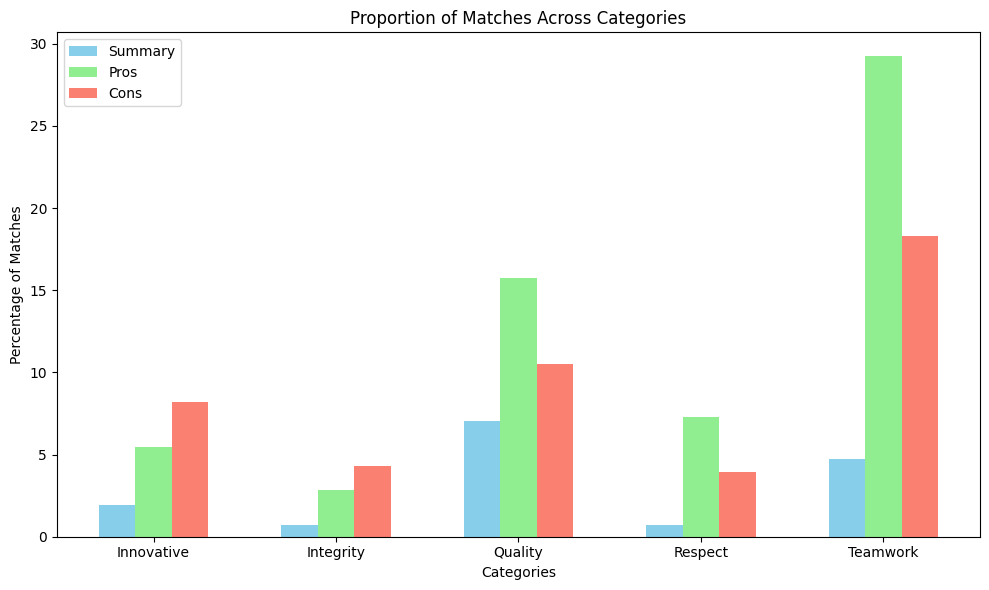

In [10]:
row_num = len(df)

summary_cols = ['summary_innovative', 'summary_integrity', 'summary_quality', 'summary_respect', 'summary_teamwork']
pros_cols = ['pros_innovative', 'pros_integrity', 'pros_quality', 'pros_respect', 'pros_teamwork']
cons_cols = ['cons_innovative', 'cons_integrity', 'cons_quality', 'cons_respect', 'cons_teamwork']

proportions_summary = [df[col].sum() / row_num * 100 for col in summary_cols]
proportions_pros = [df[col].sum() / row_num * 100 for col in pros_cols]
proportions_cons = [df[col].sum() / row_num * 100 for col in cons_cols]

print('number of rows:', row_num)

categories = ['Innovative', 'Integrity', 'Quality', 'Respect', 'Teamwork']

x = np.arange(len(categories))
bar_width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, proportions_summary, width=bar_width, label='Summary', color='skyblue')
plt.bar(x, proportions_pros, width=bar_width, label='Pros', color='lightgreen')
plt.bar(x + bar_width, proportions_cons, width=bar_width, label='Cons', color='salmon')

plt.xlabel('Categories')
plt.ylabel('Percentage of Matches')
plt.title('Proportion of Matches Across Categories')

plt.xticks(x, categories)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
df['innovative'] = df[['summary_innovative', 'pros_innovative', 'cons_innovative']].any(axis=1)
df['integrity'] = df[['summary_integrity', 'pros_integrity', 'cons_integrity']].any(axis=1)
df['quality'] = df[['summary_quality', 'pros_quality', 'cons_quality']].any(axis=1)
df['respect'] = df[['summary_respect', 'pros_respect', 'cons_respect']].any(axis=1)
df['teamwork'] = df[['summary_teamwork', 'pros_teamwork', 'cons_teamwork']].any(axis=1)

In [16]:
df.shape

(4320624, 27)

In [18]:
row_num = df.shape[0]

print(df['innovative'].sum(), df['innovative'].sum() / row_num * 100)
print(df['integrity'].sum(), df['integrity'].sum() / row_num * 100)
print(df['quality'].sum(), df['quality'].sum() / row_num * 100)
print(df['respect'].sum(), df['respect'].sum() / row_num * 100)
print(df['teamwork'].sum(), df['teamwork'].sum() / row_num * 100)

593475 13.735863153100109
321497 7.440985376186402
1209054 27.983319076133444
486901 11.269228704002014
1829798 42.350317917041615


In [9]:
df.to_parquet(path_to_folder+'/data_checkpoint/3.matching.parquet')

### 4. calculate scores using matching rules
- version 1 scores
- ready to use for alpha generation

In [10]:
df = pd.read_parquet(path_to_folder+'/data_checkpoint/3.matching.parquet')

In [11]:
# logic:
def calculate_score(pros_value, cons_value):
  if pros_value == True and cons_value == False:
    return 1
  elif pros_value == False and cons_value == False:
    return 0
  elif pros_value == True and cons_value == True:
    return 0
  elif pros_value == False and cons_value == True:
    return -1

df['innovative_score'] = np.where((df['pros_innovative'] == True) & (df['cons_innovative'] == False), 1,
                          np.where((df['pros_innovative'] == False) & (df['cons_innovative'] == True), -1, 0))

df['integrity_score'] = np.where((df['pros_integrity'] == True) & (df['cons_integrity'] == False), 1,
                          np.where((df['pros_integrity'] == False) & (df['cons_integrity'] == True), -1, 0))

df['quality_score'] = np.where((df['pros_quality'] == True) & (df['cons_quality'] == False), 1,
                        np.where((df['pros_quality'] == False) & (df['cons_quality'] == True), -1, 0))

df['respect_score'] = np.where((df['pros_respect'] == True) & (df['cons_respect'] == False), 1,
                        np.where((df['pros_respect'] == False) & (df['cons_respect'] == True), -1, 0))

df['teamwork_score'] = np.where((df['pros_teamwork'] == True) & (df['cons_teamwork'] == False), 1,
                         np.where((df['pros_teamwork'] == False) & (df['cons_teamwork'] == True), -1, 0))

In [12]:
df_matching_score = df[['reviewId', 'innovative_score', 'integrity_score', 'quality_score', 'respect_score', 'teamwork_score']]
df_matching_score.head()

,reviewId,innovative_score,integrity_score,quality_score,respect_score,teamwork_score
0,49,0,0,1,0,1
1,59,0,0,1,0,1
2,77,0,0,0,0,0
3,81,0,0,0,0,1
4,83,1,1,0,0,-1


In [13]:
df_matching_score.to_parquet(path_to_folder+'/data_checkpoint/4.matching_rule_to_scores.parquet')

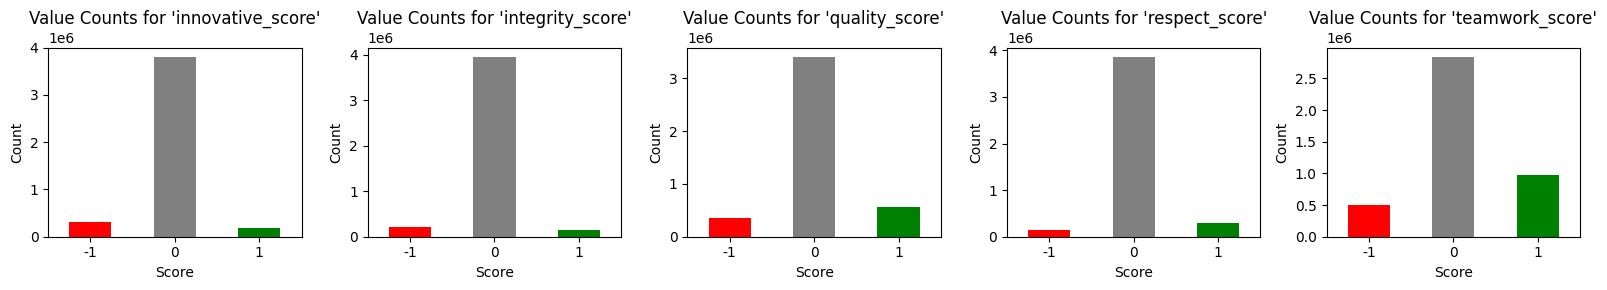

In [14]:
columns = ['innovative_score', 'integrity_score', 'quality_score', 'respect_score', 'teamwork_score']

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16, 3))

for ax, col in zip(axes, columns):
  df[col].value_counts().sort_index().plot(kind='bar', ax=ax, color=['red', 'gray', 'green'])
  
  ax.set_title(f"Value Counts for '{col}'")
  ax.set_ylabel("Count")
  ax.set_xlabel("Score")
  
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

### 5. use matching result to preprocess for LLM

In [3]:
df = pd.read_parquet(path_to_folder+'/data_checkpoint/3.matching.parquet')
df.shape

(4320624, 22)

In [4]:
df = df.drop(['summary_token', 'pros_token', 'cons_token'], axis=1)

# return True if match in any col
df['innovative'] = df['summary_innovative'] | df['pros_innovative'] | df['cons_innovative']
df['integrity'] = df['summary_integrity'] | df['pros_integrity'] | df['cons_integrity']
df['quality'] = df['summary_quality'] | df['pros_quality'] | df['cons_quality']
df['respect'] = df['summary_respect'] | df['pros_respect'] | df['cons_respect']
df['teamwork'] = df['summary_teamwork'] | df['pros_teamwork'] | df['cons_teamwork']

# drop rows
df = df[['reviewId', 'summary', 'pros', 'cons', 'innovative', 'integrity', 'quality', 'respect', 'teamwork']]

# remove reviews with insufficient words
threshhold = 20
df_filter = df[~((df['summary'].str.len() < threshhold) & (df['cons'].str.len() < threshhold) & (df['pros'].str.len() < threshhold))]

# show removed rows
tmp = df[((df['summary'].str.len() < threshhold) & (df['cons'].str.len() < threshhold) & (df['pros'].str.len() < threshhold))]
print("dropped:", tmp.shape)
tmp.head()

dropped: (211, 9)


,reviewId,summary,pros,cons,innovative,integrity,quality,respect,teamwork
4424,30639,kenworth,location . . . .,pay . . . .,False,False,False,False,False
195646,2269058,apple,fun to be at apple,have to put in time,False,False,False,False,False
458067,5532404,good place to work,"good work, , ,","nothing, , , , , ,",False,False,False,False,False
474284,5717805,awesome,good company . . .,no concers . . .,False,False,False,False,False
491337,5914082,fraud dept,worked 4 days a wk,pay is too low,False,False,False,False,False


In [5]:
# remove reviews with insufficient words
df_filter = df_filter[ (df_filter['summary'].str.len() + df_filter['pros'].str.len() + df_filter['cons'].str.len()) > 40 ]

print(df_filter.shape)
df_filter.head(3)

(4320365, 9)


,reviewId,summary,pros,cons,innovative,integrity,quality,respect,teamwork
0,49,a great internship experience.,all people are helpful. we create products tha...,"no, i don't really think there's any downside.",False,False,True,False,True
1,59,microsoft - when it stopped treating all of it...,lots of smart folks doing a wide variety of th...,unless you are a partner the company treats yo...,False,False,True,False,True
2,77,"good company to work for, but keep in mind tha...",the culture of the company is one of the best ...,apple is a very exclusive company to work for ...,False,False,True,False,False


In [6]:
df_innovative = df_filter[df_filter['innovative']==True]
df_integrity = df_filter[df_filter['integrity']==True]
df_quality = df_filter[df_filter['quality']==True]
df_respect = df_filter[df_filter['respect']==True]
df_teamwork = df_filter[df_filter['teamwork']==True]

In [7]:
cols_to_remove = ['innovative', 'integrity', 'quality', 'respect', 'teamwork']

df_innovative = df_innovative.drop(cols_to_remove, axis=1)
df_integrity = df_integrity.drop(cols_to_remove, axis=1)
df_quality = df_quality.drop(cols_to_remove, axis=1)
df_respect = df_respect.drop(cols_to_remove, axis=1)
df_teamwork = df_teamwork.drop(cols_to_remove, axis=1)

In [8]:
# sort for LLM: similar tensor length -> increase speed

sorting_cols = ['summary', 'pros', 'cons']

df_innovative = df_innovative.sort_values(
  by = sorting_cols,
  key = lambda col: col.apply(lambda row: sum(len(str(x)) for x in row)),
  ascending=False
).reset_index(drop=True)

df_integrity = df_integrity.sort_values(
  by = sorting_cols,
  key = lambda col: col.apply(lambda row: sum(len(str(x)) for x in row)),
  ascending=False
).reset_index(drop=True)

df_quality = df_quality.sort_values(
  by = sorting_cols,
  key = lambda col: col.apply(lambda row: sum(len(str(x)) for x in row)),
  ascending=False
).reset_index(drop=True)

df_respect = df_respect.sort_values(
  by = sorting_cols,
  key = lambda col: col.apply(lambda row: sum(len(str(x)) for x in row)),
  ascending=False
).reset_index(drop=True)

df_teamwork = df_teamwork.sort_values(
  by = sorting_cols,
  key = lambda col: col.apply(lambda row: sum(len(str(x)) for x in row)),
  ascending=False
).reset_index(drop=True)

In [9]:
print(df_innovative.shape)
print(df_integrity.shape)
print(df_quality.shape)
print(df_respect.shape)
print(df_teamwork.shape)

(593715, 4)
(406675, 4)
(1217294, 4)
(486899, 4)
(1829790, 4)


In [10]:
df_innovative_batch1 = df_innovative.iloc[0:200000]
df_innovative_batch2 = df_innovative.iloc[200000:400000]
df_innovative_batch3 = df_innovative.iloc[400000:-1]

df_innovative_batch1.to_parquet(path_to_folder+'/preprocess_LLM/innovative_batch1.parquet')
df_innovative_batch2.to_parquet(path_to_folder+'/preprocess_LLM/innovative_batch2.parquet')
df_innovative_batch3.to_parquet(path_to_folder+'/preprocess_LLM/innovative_batch3.parquet')

In [11]:
df_integrity_batch1 = df_integrity.iloc[0:140000]
df_integrity_batch2 = df_integrity.iloc[140000:280000]
df_integrity_batch3 = df_integrity.iloc[280000:-1]

df_integrity_batch1.to_parquet(path_to_folder+'/preprocess_LLM/integrity_batch1.parquet')
df_integrity_batch2.to_parquet(path_to_folder+'/preprocess_LLM/integrity_batch2.parquet')
df_integrity_batch3.to_parquet(path_to_folder+'/preprocess_LLM/integrity_batch3.parquet')

In [12]:
df_quality_batch1 = df_quality.iloc[0:400000]
df_quality_batch2 = df_quality.iloc[400000:800000]
df_quality_batch3 = df_quality.iloc[800000:-1]

df_quality_batch1.to_parquet(path_to_folder+'/preprocess_LLM/quality_batch1.parquet')
df_quality_batch2.to_parquet(path_to_folder+'/preprocess_LLM/quality_batch2.parquet')
df_quality_batch3.to_parquet(path_to_folder+'/preprocess_LLM/quality_batch3.parquet')

In [13]:
df_respect_batch1 = df_respect.iloc[0:160000]
df_respect_batch2 = df_respect.iloc[160000:320000]
df_respect_batch3 = df_respect.iloc[320000:-1]

df_respect_batch1.to_parquet(path_to_folder+'/preprocess_LLM/respect_batch1.parquet')
df_respect_batch2.to_parquet(path_to_folder+'/preprocess_LLM/respect_batch2.parquet')
df_respect_batch3.to_parquet(path_to_folder+'/preprocess_LLM/respect_batch3.parquet')

In [14]:
df_teamwork_batch1 = df_teamwork.iloc[0:300000]
df_teamwork_batch2 = df_teamwork.iloc[300000:600000]
df_teamwork_batch3 = df_teamwork.iloc[600000:900000]
df_teamwork_batch4 = df_teamwork.iloc[900000:1200000]
df_teamwork_batch5 = df_teamwork.iloc[1200000:1500000]
df_teamwork_batch6 = df_teamwork.iloc[1500000:-1]

df_teamwork_batch1.to_parquet(path_to_folder+'/preprocess_LLM/teamwork_batch1.parquet')
df_teamwork_batch2.to_parquet(path_to_folder+'/preprocess_LLM/teamwork_batch2.parquet')
df_teamwork_batch3.to_parquet(path_to_folder+'/preprocess_LLM/teamwork_batch3.parquet')
df_teamwork_batch4.to_parquet(path_to_folder+'/preprocess_LLM/teamwork_batch4.parquet')
df_teamwork_batch5.to_parquet(path_to_folder+'/preprocess_LLM/teamwork_batch5.parquet')
df_teamwork_batch6.to_parquet(path_to_folder+'/preprocess_LLM/teamwork_batch6.parquet')

### 6. Vader Sentiment Analyzer

In [30]:
df_import = pd.read_parquet(path_to_folder+'/data_checkpoint/1.cleaned_text.parquet')

In [31]:
df = df_import.copy()
df.columns

Index(['reviewId', 'summary', 'pros', 'cons'], dtype='object')

In [32]:
analyzer = SentimentIntensityAnalyzer()

df['summary_sentiment'] = df['summary'].swifter.apply(lambda text: analyzer.polarity_scores(text)['compound'])
df['pros_sentiment'] = df['pros'].swifter.apply(lambda text: analyzer.polarity_scores(text)['compound'])
df['cons_sentiment'] = df['cons'].swifter.apply(lambda text: analyzer.polarity_scores(text)['compound'])

df['overall_sentiment'] = (df['summary_sentiment'] + df['pros_sentiment'] + df['cons_sentiment']) / 3

df = df[['reviewId', 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'overall_sentiment']]

In [33]:
df.head()

,reviewId,summary_sentiment,pros_sentiment,cons_sentiment,overall_sentiment
0,49,0.6249,0.5994,-0.2500,0.324767
1,59,-0.0258,0.9153,0.3612,0.416900
2,77,0.2382,0.9825,0.2247,0.481800
3,81,0.0000,0.9534,-0.2418,0.237200
4,83,0.0000,0.9671,0.1756,0.380900


In [34]:
df.to_parquet(path_to_folder+'/data_checkpoint/6.sentiment_vader.parquet')

### 7. matching rule scores with vader sentiment

In [4]:
df_sentiment = pd.read_parquet(path_to_folder+'/data_checkpoint/6.sentiment_vader.parquet')
df_matching = pd.read_parquet(path_to_folder+'/data_checkpoint/3.matching.parquet')

In [5]:
df_matching.drop(['summary', 'pros', 'cons', 'summary_token', 'pros_token', 'cons_token'], axis=1, inplace=True)

cols = ['summary_innovative', 'summary_integrity', 'summary_quality', 'summary_respect', 'summary_teamwork',
       'pros_innovative', 'pros_integrity', 'pros_quality', 'pros_respect', 'pros_teamwork',
       'cons_innovative', 'cons_integrity', 'cons_quality', 'cons_respect', 'cons_teamwork']

for col in cols:
  df_matching[col] = df_matching[col].replace({True: 1, False: 0})

In [6]:
df = pd.merge(df_matching, df_sentiment, on='reviewId', how='inner')

In [7]:
cols_sentiment = ['summary_sentiment', 'pros_sentiment', 'cons_sentiment']

cols_innovative = ['summary_innovative', 'pros_innovative', 'cons_innovative']
cols_integrity = ['summary_integrity', 'pros_integrity', 'cons_integrity']
cols_quality = ['summary_quality', 'pros_quality', 'cons_quality']
cols_respect = ['summary_respect', 'pros_respect', 'cons_respect']
cols_teamwork = ['summary_teamwork', 'pros_teamwork', 'cons_teamwork']

for i in range(3):
  df[cols_innovative[i]] = df[cols_innovative[i]] * df[cols_sentiment[i]]
  df[cols_integrity[i]] = df[cols_integrity[i]] * df[cols_sentiment[i]]
  df[cols_quality[i]] = df[cols_quality[i]] * df[cols_sentiment[i]]
  df[cols_respect[i]] = df[cols_respect[i]] * df[cols_sentiment[i]]
  df[cols_teamwork[i]] = df[cols_teamwork[i]] * df[cols_sentiment[i]]

def signed_max_abs(row):
  abs_max_index = np.argmax(np.abs(row))
  return row[abs_max_index]

df['innovative'] = df[cols_innovative].swifter.apply(signed_max_abs, axis=1)
df['integrity'] = df[cols_integrity].swifter.apply(signed_max_abs, axis=1)
df['quality'] = df[cols_quality].swifter.apply(signed_max_abs, axis=1)
df['respect'] = df[cols_respect].swifter.apply(signed_max_abs, axis=1)
df['teamwork'] = df[cols_teamwork].swifter.apply(signed_max_abs, axis=1)

Dask Apply:   0%|          | 0/33 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/33 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/33 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/33 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/33 [00:00<?, ?it/s]

In [8]:
df = df[['reviewId', 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'overall_sentiment','innovative', 'integrity', 'quality', 'respect', 'teamwork']]

In [9]:
print(df.shape)
df.head()

(4320624, 10)


,reviewId,summary_sentiment,pros_sentiment,cons_sentiment,overall_sentiment,innovative,integrity,quality,respect,teamwork
0,49,0.6249,0.5994,-0.2500,0.324767,0.0000,0.0000,0.5994,0.0,0.5994
1,59,-0.0258,0.9153,0.3612,0.416900,-0.0000,-0.0000,0.9153,-0.0,0.9153
2,77,0.2382,0.9825,0.2247,0.481800,0.0000,0.0000,0.9825,0.0,0.0000
3,81,0.0000,0.9534,-0.2418,0.237200,0.0000,0.0000,0.0000,0.0,0.9534
4,83,0.0000,0.9671,0.1756,0.380900,0.9671,0.9671,0.9671,0.0,0.1756


In [10]:
df.to_parquet(path_to_folder+'/data_checkpoint/7.sentiment_vader_aspect_matching.parquet')

### 8. distillbert sentiment

In [ ]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
from transformers import pipeline
from datasets import load_dataset
from torch.utils.data import DataLoader
import json

In [ ]:
classifier = pipeline('sentiment-analysis', model='distilbert/distilbert-base-uncased-finetuned-sst-2-english', device=0)

def collate_fn(batch):
  review_ids = [row['reviewId'] for row in batch]
  
  # 512 length limitation of this model
  max_length = 512
  batch_summary = [row['summary'][:max_length] for row in batch]
  batch_pros = [row['pros'][:max_length] for row in batch]
  batch_cons = [row['cons'][:max_length] for row in batch]

  return review_ids, batch_summary, batch_pros, batch_cons

filepath = "C:/Users/phku0/Quant_Project/data_checkpoint/1.cleaned_text.parquet"
dataset = load_dataset("parquet", data_files=filepath)["train"]
# dataset = dataset.select(range(0,100))
dataloader = DataLoader(dataset, batch_size=128, collate_fn=collate_fn, shuffle=False, num_workers=0)

def sentiment_to_score(sentiment_dict):
  if sentiment_dict['label'] == 'POSITIVE':
    score = sentiment_dict['score']
  elif sentiment_dict['label'] == 'NEGATIVE':
    score = -sentiment_dict['score']
  else:
    score = 0
  return score

results_list = []

output_filepath = "C:/Users/phku0/Quant_Project/data_checkpoint/7.sentiment_distilbert.json"
with open(output_filepath, "w") as outfile:
  for batch in tqdm(dataloader):
    review_ids, batch_summary, batch_pros, batch_cons = batch

    summary_result = classifier(batch_summary)
    pros_result = classifier(batch_pros)
    cons_result = classifier(batch_cons)

    summary_sentiment = [sentiment_to_score(result) for result in summary_result]
    pros_sentiment = [sentiment_to_score(result) for result in pros_result]
    cons_sentiment = [sentiment_to_score(result) for result in cons_result]

    for i in range(len(review_ids)):
      result_dict = {
        "reviewId": review_ids[i],
        "summary_sentiment": summary_sentiment[i],
        "pros_sentiment": pros_sentiment[i],
        "cons_sentiment": cons_sentiment[i]
      }
      outfile.write(json.dumps(result_dict) + "\n")

In [ ]:
df = pd.read_json("C:/Users/phku0/Quant_Project/data_checkpoint/7.sentiment_distilbert.json", lines=True)
df.shape
df.head()

In [ ]:
df = pd.read_json("C:/Users/phku0/Quant_Project/data_checkpoint/7.sentiment_distilbert.json", lines=True)
df.shape
df.head()

### 9. matching rule scores with distillbert sentiment

In [3]:
df_sentiment = pd.read_parquet(path_to_folder+'/data_checkpoint/8.sentiment_distilbert.parquet')
df_sentiment['overall_sentiment'] = (df_sentiment['summary_sentiment'] + df_sentiment['pros_sentiment'] + df_sentiment['cons_sentiment']) / 3
df_sentiment.head()

,reviewId,summary_sentiment,pros_sentiment,cons_sentiment,overall_sentiment
0,49,0.999667,0.999435,-0.999216,0.333295
1,59,-0.996828,0.999867,-0.992616,-0.329859
2,77,0.999640,0.999834,-0.999324,0.333383
3,81,0.997240,0.994371,0.628813,0.873475
4,83,0.991291,0.994669,-0.999427,0.328844


In [4]:
df_matching = pd.read_parquet(path_to_folder+'/data_checkpoint/3.matching.parquet')

df_matching.drop(['summary', 'pros', 'cons', 'summary_token', 'pros_token', 'cons_token'], axis=1, inplace=True)

cols = ['summary_innovative', 'summary_integrity', 'summary_quality', 'summary_respect', 'summary_teamwork',
       'pros_innovative', 'pros_integrity', 'pros_quality', 'pros_respect', 'pros_teamwork',
       'cons_innovative', 'cons_integrity', 'cons_quality', 'cons_respect', 'cons_teamwork']

for col in cols:
  df_matching[col] = df_matching[col].replace({True: 1, False: 0})

In [5]:
df = pd.merge(df_matching, df_sentiment, on='reviewId', how='inner')

In [6]:
cols_sentiment = ['summary_sentiment', 'pros_sentiment', 'cons_sentiment']

cols_innovative = ['summary_innovative', 'pros_innovative', 'cons_innovative']
cols_integrity = ['summary_integrity', 'pros_integrity', 'cons_integrity']
cols_quality = ['summary_quality', 'pros_quality', 'cons_quality']
cols_respect = ['summary_respect', 'pros_respect', 'cons_respect']
cols_teamwork = ['summary_teamwork', 'pros_teamwork', 'cons_teamwork']

for i in range(3):
  df[cols_innovative[i]] = df[cols_innovative[i]] * df[cols_sentiment[i]]
  df[cols_integrity[i]] = df[cols_integrity[i]] * df[cols_sentiment[i]]
  df[cols_quality[i]] = df[cols_quality[i]] * df[cols_sentiment[i]]
  df[cols_respect[i]] = df[cols_respect[i]] * df[cols_sentiment[i]]
  df[cols_teamwork[i]] = df[cols_teamwork[i]] * df[cols_sentiment[i]]

def signed_max_abs(row):
  abs_max_index = np.argmax(np.abs(row))
  return row[abs_max_index]

df['innovative'] = df[cols_innovative].swifter.apply(signed_max_abs, axis=1)
df['integrity'] = df[cols_integrity].swifter.apply(signed_max_abs, axis=1)
df['quality'] = df[cols_quality].swifter.apply(signed_max_abs, axis=1)
df['respect'] = df[cols_respect].swifter.apply(signed_max_abs, axis=1)
df['teamwork'] = df[cols_teamwork].swifter.apply(signed_max_abs, axis=1)

Dask Apply:   0%|          | 0/33 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/33 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/33 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/33 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/33 [00:00<?, ?it/s]

In [7]:
df = df[['reviewId', 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'overall_sentiment','innovative', 'integrity', 'quality', 'respect', 'teamwork']]

In [8]:
print(df.shape)
df.head()

(4320624, 10)


,reviewId,summary_sentiment,pros_sentiment,cons_sentiment,overall_sentiment,innovative,integrity,quality,respect,teamwork
0,49,0.999667,0.999435,-0.999216,0.333295,0.000000,0.000000,0.999435,0.0,0.999435
1,59,-0.996828,0.999867,-0.992616,-0.329859,-0.000000,-0.000000,0.999867,-0.0,0.999867
2,77,0.999640,0.999834,-0.999324,0.333383,0.000000,0.000000,0.999834,0.0,0.000000
3,81,0.997240,0.994371,0.628813,0.873475,0.000000,0.000000,0.000000,0.0,0.994371
4,83,0.991291,0.994669,-0.999427,0.328844,0.994669,0.994669,-0.999427,0.0,-0.999427


In [9]:
df.to_parquet(path_to_folder+'/data_checkpoint/9.sentiment_distillbert_aspect_matching.parquet')

### 10. roberta sentiment

In [ ]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
from transformers import pipeline
from datasets import load_dataset
from torch.utils.data import DataLoader
import json

In [ ]:
classifier = pipeline('sentiment-analysis', model='cardiffnlp/twitter-roberta-base-sentiment', device=0)

def collate_fn(batch):
  review_ids = [row['reviewId'] for row in batch]
  
  # length limitation?
  max_length = 1024
  batch_summary = [row['summary'][:max_length] for row in batch]
  batch_pros = [row['pros'][:max_length] for row in batch]
  batch_cons = [row['cons'][:max_length] for row in batch]
  batch_advice = [row['advice'][:max_length] for row in batch]

  return review_ids, batch_summary, batch_pros, batch_cons, batch_advice

filepath = "C:/Users/phku0/Quant_Project/data_checkpoint/1.cleaned_text.parquet"
dataset = load_dataset("parquet", data_files=filepath)["train"]
# dataset = dataset.select(range(0,3000))
dataloader = DataLoader(dataset, batch_size=11000, collate_fn=collate_fn, shuffle=False, num_workers=0)

def sentiment_to_score(sentiment_dict):
  if sentiment_dict['label'] == 'LABEL_2':
    score = sentiment_dict['score']
  elif sentiment_dict['label'] == 'LABEL_0':
    score = -sentiment_dict['score']
  else:
    score = 0
  return score

results_list = []

output_filepath = "C:/Users/phku0/Quant_Project/data_checkpoint/10.sentiment_roberta.json"
with open(output_filepath, "w") as outfile:
  for batch in tqdm(dataloader):
    review_ids, batch_summary, batch_pros, batch_cons, batch_advice = batch

    summary_result = classifier(batch_summary)
    pros_result = classifier(batch_pros)
    cons_result = classifier(batch_cons)
    advice_result = classifier(batch_advice)

    summary_sentiment = [sentiment_to_score(result) for result in summary_result]
    pros_sentiment = [sentiment_to_score(result) for result in pros_result]
    cons_sentiment = [sentiment_to_score(result) for result in cons_result]
    advice_sentiment = [sentiment_to_score(result) for result in advice_result]

    for i in range(len(review_ids)):
      result_dict = {
        "reviewId": review_ids[i],
        "summary_sentiment": summary_sentiment[i],
        "pros_sentiment": pros_sentiment[i],
        "cons_sentiment": cons_sentiment[i],
        "advice_sentiment": advice_sentiment[i]
      }
      outfile.write(json.dumps(result_dict) + "\n")


In [ ]:
df = pd.read_json("C:/Users/phku0/Quant_Project/data_checkpoint/10.sentiment_roberta.json", lines=True)
print(df.shape)
df.head()

In [ ]:
df.to_parquet("C:/Users/phku0/Quant_Project/data_checkpoint/10.sentiment_roberta.parquet")

### 11. matching rule scores with roberta sentiment

In [20]:
df_sentiment = pd.read_parquet(path_to_folder+'/data_checkpoint/10.sentiment_roberta.parquet')
df_sentiment['overall_sentiment'] = (df_sentiment['summary_sentiment'] + df_sentiment['pros_sentiment'] + df_sentiment['cons_sentiment']) / 3
df_sentiment.head()

,reviewId,summary_sentiment,pros_sentiment,cons_sentiment,overall_sentiment
0,49,0.958085,0.951453,0.000000,0.636513
1,59,-0.830964,0.956963,0.000000,0.042000
2,77,0.867430,0.955116,-0.576136,0.415470
3,81,0.545637,0.930963,0.000000,0.492200
4,83,0.000000,0.949141,-0.825076,0.041355


In [21]:
df_matching = pd.read_parquet(path_to_folder+'/data_checkpoint/3.matching.parquet')

df_matching.drop(['summary', 'pros', 'cons', 'summary_token', 'pros_token', 'cons_token'], axis=1, inplace=True)

cols = ['summary_innovative', 'summary_integrity', 'summary_quality', 'summary_respect', 'summary_teamwork',
       'pros_innovative', 'pros_integrity', 'pros_quality', 'pros_respect', 'pros_teamwork',
       'cons_innovative', 'cons_integrity', 'cons_quality', 'cons_respect', 'cons_teamwork']

for col in cols:
  df_matching[col] = df_matching[col].replace({True: 1, False: 0})

In [24]:
df = pd.merge(df_matching, df_sentiment, on='reviewId', how='inner')

In [27]:
cols_sentiment = ['summary_sentiment', 'pros_sentiment', 'cons_sentiment']

cols_innovative = ['summary_innovative', 'pros_innovative', 'cons_innovative']
cols_integrity = ['summary_integrity', 'pros_integrity', 'cons_integrity']
cols_quality = ['summary_quality', 'pros_quality', 'cons_quality']
cols_respect = ['summary_respect', 'pros_respect', 'cons_respect']
cols_teamwork = ['summary_teamwork', 'pros_teamwork', 'cons_teamwork']

for i in range(3):
  df[cols_innovative[i]] = df[cols_innovative[i]] * df[cols_sentiment[i]]
  df[cols_integrity[i]] = df[cols_integrity[i]] * df[cols_sentiment[i]]
  df[cols_quality[i]] = df[cols_quality[i]] * df[cols_sentiment[i]]
  df[cols_respect[i]] = df[cols_respect[i]] * df[cols_sentiment[i]]
  df[cols_teamwork[i]] = df[cols_teamwork[i]] * df[cols_sentiment[i]]

def signed_max_abs(row):
  abs_max_index = np.argmax(np.abs(row))
  return row[abs_max_index]

df['innovative'] = df[cols_innovative].swifter.apply(signed_max_abs, axis=1)
df['integrity'] = df[cols_integrity].swifter.apply(signed_max_abs, axis=1)
df['quality'] = df[cols_quality].swifter.apply(signed_max_abs, axis=1)
df['respect'] = df[cols_respect].swifter.apply(signed_max_abs, axis=1)
df['teamwork'] = df[cols_teamwork].swifter.apply(signed_max_abs, axis=1)

Dask Apply:   0%|          | 0/33 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/33 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/33 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/33 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/33 [00:00<?, ?it/s]

In [28]:
df = df[['reviewId', 'summary_sentiment', 'pros_sentiment', 'cons_sentiment', 'overall_sentiment','innovative', 'integrity', 'quality', 'respect', 'teamwork']]

In [29]:
print(df.shape)
df.head()

(4320624, 10)


,reviewId,summary_sentiment,pros_sentiment,cons_sentiment,overall_sentiment,innovative,integrity,quality,respect,teamwork
0,49,0.958085,0.951453,0.000000,0.636513,0.000000,0.000000,0.951453,0.0,0.951453
1,59,-0.830964,0.956963,0.000000,0.042000,-0.000000,-0.000000,0.956963,-0.0,0.956963
2,77,0.867430,0.955116,-0.576136,0.415470,0.000000,0.000000,0.955116,0.0,0.000000
3,81,0.545637,0.930963,0.000000,0.492200,0.000000,0.000000,0.000000,0.0,0.930963
4,83,0.000000,0.949141,-0.825076,0.041355,0.949141,0.949141,0.949141,0.0,-0.825076


In [30]:
df.to_parquet(path_to_folder+'/data_checkpoint/11.sentiment_roberta_aspect_matching.parquet')

### 12. LLM template using part 5 preprocessed data

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from tqdm import tqdm
import time
import pandas as pd
import json

model_name = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
model = AutoModelForCausalLM.from_pretrained(
  model_name,
  torch_dtype=torch.float16,
  trust_remote_code=True
).to("cuda")

if tokenizer.pad_token_id is None:
  tokenizer.pad_token_id = tokenizer.eos_token_id
if model.config.pad_token_id is None:
  model.config.pad_token_id = model.config.eos_token_id
if model.config.bos_token_id is None:
  model.config.bos_token_id = tokenizer.bos_token_id
if model.config.eos_token_id is None:
  model.config.eos_token_id = tokenizer.eos_token_id
if model.generation_config.pad_token_id is None:
  model.generation_config.pad_token_id = tokenizer.pad_token_id

In [ ]:
# template: change aspect, input file path and output file path

# Function to create prompts
def make_prompt(aspect, summary, pros, cons):
  system_msg = f"""
You are an Aspect-Based Sentiment Analysis assistant.
Your task is to analyze the sentiment of text concerning a specific aspect: '{aspect}'.

For each review provided by the user, you will give a sentiment score between 0 and 1 for the aspect '{aspect}'.
The score should reflect how positive or negative the review is specifically towards '{aspect}', where:
- 0 means very negative
- 0.5 means neutral
- 1 means very positive

If the '{aspect}' is not mentioned in the review, return a score of 0.5.
Please respond only with a number between 0 and 1, rounded to two decimal places\n
"""

  user_msg = f"""
Text to analyze:
Summary: {summary}
Pros: {pros}
Cons: {cons}

Based on the text above, return one number towards '{aspect}', without any additional explanation.
"""
  return system_msg + user_msg

# Custom Dataset class for PyTorch
class AspectSentimentDataset(Dataset):
  def __init__(self, dataset, aspect="quality"):
    self.dataset = dataset
    self.aspect = aspect

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    # Extract individual rows from the dataset
    summary = self.dataset[idx]['summary']
    pros = self.dataset[idx]['pros']
    cons = self.dataset[idx]['cons']
    review_id = self.dataset[idx]['reviewId']

    # Create the prompt
    prompt = make_prompt(self.aspect, summary, pros, cons)

    return {"prompt": prompt, "reviewId": review_id}

# Collate function for DataLoader
def collate_fn(batch):
  # Extract prompts
  prompts = [item['prompt'] for item in batch]

  # Tokenize the prompts
  tokenized_inputs = tokenizer(
    prompts,
    padding=True,
    truncation=True,
    max_length=3000,
    return_tensors="pt",
  )

  # Move tokenized inputs to the GPU
  tokenized_inputs = {key: val.to(model.device) for key, val in tokenized_inputs.items()}

  # Also return the reviewIds to keep track of the results
  review_ids = [item['reviewId'] for item in batch]

  return tokenized_inputs, review_ids

# Function for processing batches
def process_batch(model, tokenized_inputs):
  with torch.no_grad():  # Disable gradient calculation for inference
    outputs = model.generate(
      **tokenized_inputs,
      max_new_tokens=3,
      do_sample = False,
      top_p=0.3,
    )

  return outputs

dataset = load_dataset("parquet", data_files="/content/drive/MyDrive/Colab Notebooks/quant_project/data/quality_batch1.parquet")["train"]
# dataset = dataset.select(range(1, 100))

torch_dataset = AspectSentimentDataset(dataset)

batch_size = 1
dataloader = DataLoader(torch_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

total_batches = len(dataloader)

with open("/content/drive/MyDrive/Colab Notebooks/quant_project/data_output/quality_batch1b_output.json", "w") as outfile:
  for batch in tqdm(dataloader, total=total_batches, desc="Processing batches"):
    tokenized_inputs, review_ids = batch
    generated_outputs = process_batch(model, tokenized_inputs)
    generated_texts = tokenizer.batch_decode(generated_outputs, skip_special_tokens=True)

    for review_id, output in zip(review_ids, generated_texts):
      try:
        result = output.split("without any additional explanation")[1]
      except:
        result = None
      result_dict = {"reviewId": review_id, "result": result}
      outfile.write(json.dumps(result_dict) + "\n")

### 13. merge LLM outputs into one file

In [ ]:
import pandas as pd

df_inno_1 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/innovative_batch1_output.json", lines=True)
df_inno_2 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/innovative_batch2_output.json", lines=True)
df_inno_3 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/innovative_batch3_output.json", lines=True)

df_inte_1 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/integrity_batch1_output.json", lines=True)
df_inte_2 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/integrity_batch2_output.json", lines=True)
df_inte_3 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/integrity_batch3_output.json", lines=True)

df_qua_1 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/quality_batch1_output.json", lines=True)
df_qua_1b = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/quality_batch1b_output.json", lines=True)
df_qua_2 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/quality_batch2_output.json", lines=True)
df_qua_3 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/quality_batch3_output.json", lines=True)

df_resp_1 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/respect_batch1_output.json", lines=True)
df_resp_2 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/respect_batch2_output.json", lines=True)
df_resp_3 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/respect_batch3_output.json", lines=True)

df_team_1 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/teamwork_batch1_output.json", lines=True)
df_team_2 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/teamwork_batch2_output.json", lines=True)
df_team_3 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/teamwork_batch3_output.json", lines=True)
df_team_4 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/teamwork_batch4_output.json", lines=True)
df_team_5 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/teamwork_batch5_output.json", lines=True)
df_team_6 = pd.read_json("/content/drive/MyDrive/Colab Notebooks/LLM_outputs/teamwork_batch6_output.json", lines=True)

In [ ]:
df_inno = pd.concat([df_inno_1, df_inno_2, df_inno_3], ignore_index=True)
df_inte = pd.concat([df_inte_1, df_inte_2, df_inte_3], ignore_index=True)
df_qua = pd.concat([df_qua_1, df_qua_1b, df_qua_2, df_qua_3], ignore_index=True)
df_resp = pd.concat([df_resp_1, df_resp_2, df_resp_3], ignore_index=True)
df_team = pd.concat([df_team_1, df_team_2, df_team_3, df_team_4, df_team_5, df_team_6], ignore_index=True)

In [ ]:
df_inno.rename({'result': 'innovative'}, axis=1, inplace=True)
df_inte.rename({'result': 'integrity'}, axis=1, inplace=True)
df_qua.rename({'result': 'quality'}, axis=1, inplace=True)
df_resp.rename({'result': 'respect'}, axis=1, inplace=True)
df_team.rename({'result': 'teamwork'}, axis=1, inplace=True)

In [ ]:
df = pd.merge(df_inno, df_inte, on='reviewId', how='outer')
df = pd.merge(df, df_qua, on='reviewId', how='outer')
df = pd.merge(df, df_resp, on='reviewId', how='outer')
df = pd.merge(df, df_team, on='reviewId', how='outer')

In [ ]:
import re
import numpy as np
import swifter

pattern = re.compile('\d{1}\.\d{1,2}')

def clean_text(text):
  if pd.isna(text):
    return np.nan
  result = re.search(pattern, text)
  if result:
    return float(result.group())
  else:
    return np.nan

cols = ['innovative', 'integrity', 'quality', 'respect', 'teamwork']

df[cols] = df[cols].swifter.applymap(clean_text)

In [ ]:
df.to_parquet("/content/drive/MyDrive/Colab Notebooks/LLM_asba_output.parquet")